### PHASE 1: Data Understanding and Preparation
##### Step 1 & 2: Download Dataset and load in Python

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('uber.csv')

##### Step 3: Initial Data Exploration

In [ ]:
# View the first few rows
print(df.head())

# Dataset shape
print("Dataset Shape: ", df.shape)

# Data types and non-null counts
print(df.info())

# Summary statistics for numerical columns
print("Dataset Description: \n", df.describe())

This should show:
- The number of rows and columns
- The data types (e.g., object, float64, datetime)
- Initial understanding of fare amount, timestamps, etc.

##### Step 4: Check for Missing Values & Duplicates

In [ ]:
# Count missing values
print("Missing Values:\n", df.isnull().sum())

# Check for duplicates
print("Duplicate Rows:", df.duplicated().sum())

##### Step 5: Clean the data

In [ ]:
# Drop rows with any missing data in critical columns
df = df.dropna(subset=[
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'passenger_count'
])

# Remove invalid fare amounts (0 or negative)
df = df[df['fare_amount'] > 0]

# Remove invalid passenger counts (0 or unreasonable values like > 6)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

# Remove coordinates equal to 0 (invalid locations)
df = df[(df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0)]
df = df[(df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0)]

# Convert pickup_datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Drop rows with invalid datetime conversions (if any)
df = df.dropna(subset=['pickup_datetime'])

# Drop duplicates
df = df.drop_duplicates()

# Reset index after cleaning
df = df.reset_index(drop=True)

##### Step 6: Save Cleaned data (for Power BI import)

In [ ]:
df.to_csv('uber_cleaned.csv', index=False)
print("✅ Cleaned dataset saved as 'uber_cleaned.csv'")

### PHASE 2: Exploratory Data Analysis (EDA)
##### Step 1: Descriptive Statistics

In [ ]:
# Basic stats
print(df[['fare_amount', 'passenger_count']].describe())

# Median & Mode
print("Median Fare:", df['fare_amount'].median())
print("Mode Fare:", df['fare_amount'].mode()[0])

##### Step 2: Quartiles, Range & Outliers

In [ ]:
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['fare_amount'] < lower_bound) | (df['fare_amount'] > upper_bound)]
print("Number of outliers in fare_amount:", outliers.shape[0])

##### Step 3: Visualizing Fare Distribution

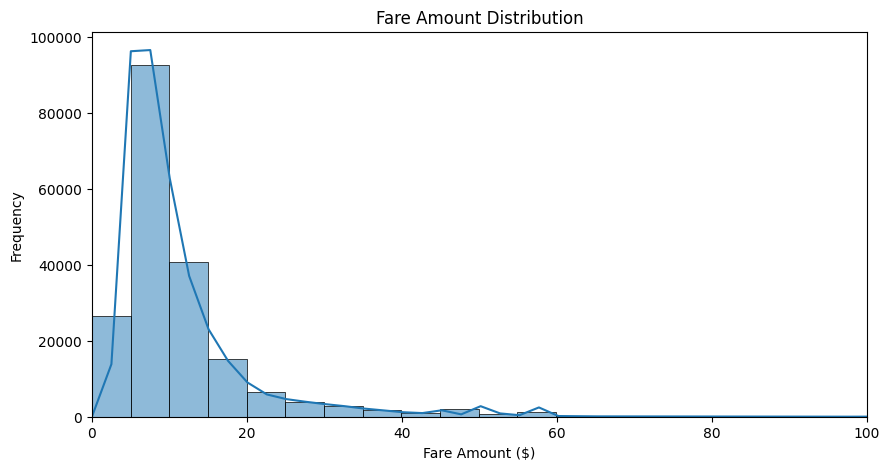

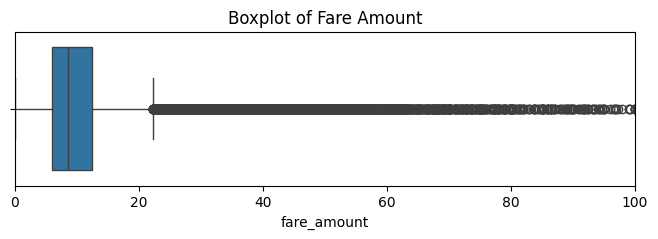

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of fare amount
plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=100, kde=True)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.xlim(0, 100)  # Zoom in for better view
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['fare_amount'])
plt.title("Boxplot of Fare Amount")
plt.xlim(0, 100)  # Limit for visibility
plt.show()

##### Step 4: Relationships Between Key Variables
1. Fare Amount vs Distance Traveled

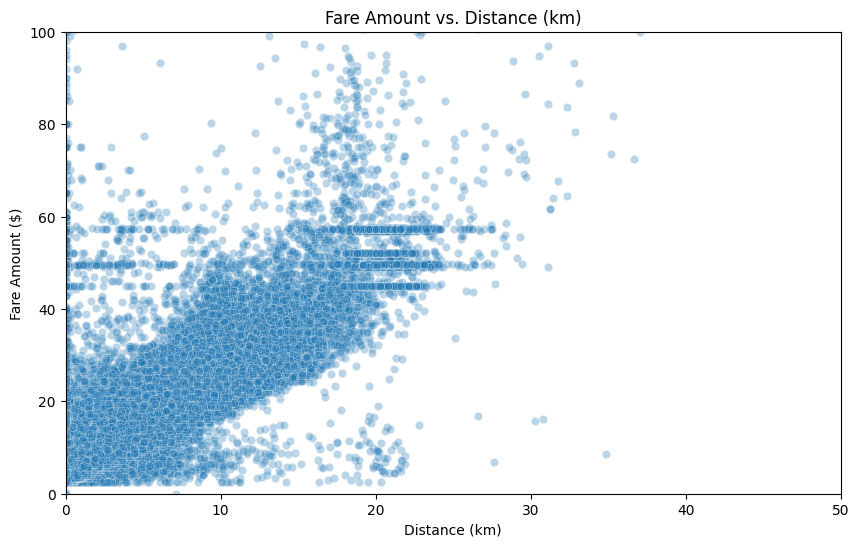

In [16]:
from math import radians, sin, cos, sqrt, atan2

# Haversine function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)

    a = sin(delta_phi/2)**2 + cos(phi1)*cos(phi2)*sin(delta_lambda/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

# Apply to dataset
df['distance_km'] = df.apply(lambda row: haversine_distance(
    row['pickup_latitude'], row['pickup_longitude'],
    row['dropoff_latitude'], row['dropoff_longitude']
), axis=1)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='distance_km', y='fare_amount', alpha=0.3)
plt.title("Fare Amount vs. Distance (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.show()

2. Fare Amount vs Time of Day

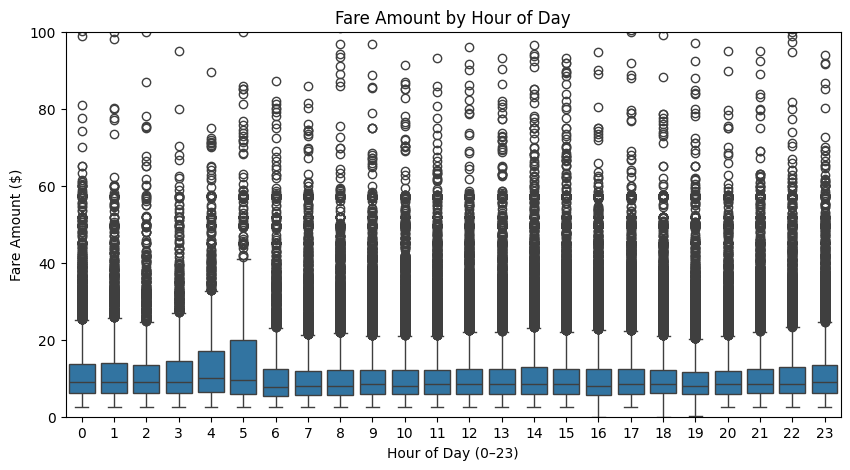

In [17]:
df['hour'] = df['pickup_datetime'].dt.hour

plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='fare_amount', data=df)
plt.title("Fare Amount by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Fare Amount ($)")
plt.ylim(0, 100)
plt.show()

3. Additional relevant correlations

In [ ]:
print(df[['fare_amount', 'passenger_count', 'distance_km']].corr())

### PHASE 3: Feature Engineering
##### Step 1: Extract Date and Time features

In [22]:
# Ensure datetime is in correct format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract time-based features
df['pickup_date'] = df['pickup_datetime'].dt.date
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['day_name'] = df['pickup_datetime'].dt.day_name()  # e.g., "Monday"

##### Step 2: Peak vs Off-Peak Indicator

In [23]:
def is_peak_hour(hour):
    return 1 if (7 <= hour <= 9) or (16 <= hour <= 19) else 0

df['is_peak'] = df['hour'].apply(is_peak_hour)

##### Step 3: Encode Categorical Variables (if needed)

In [24]:
# Example: mapping weekdays
weekday_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
               'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['weekday_encoded'] = df['day_name'].map(weekday_map)


##### Step 4: Save Enhanced Dataset

In [ ]:
df.to_csv('uber_enhanced.csv', index=False)
print("✅ Enhanced dataset saved as 'uber_enhanced.csv'")